<a href="https://colab.research.google.com/github/SLCFLAB/Data-Science-Python/blob/main/Day%2011/11_3_CNN_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN with CIFAR10

CIFAR 10은 컬러 데이터로, MNIST와는 다르게 channel이 3개가 됩니다.

CIFAR 10부터는 GPU 변경을 해주시는 것을 추천드립니다.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np
import os

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Define the normalization statistics
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

# Define the data transforms for the training set
train_tfms = transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

# Define the data transforms for the validation/test set
valid_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

# Load the CIFAR10 training set
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_tfms)

# Load the CIFAR10 validation/test set
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=valid_tfms)


100%|██████████| 170498071/170498071 [00:05<00:00, 33196924.34it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [15]:
from torch.utils.data import random_split
batch_size = 128
# Define the size of the validation set as a percentage of the total dataset
val_size = 0.2

# Calculate the size of the validation set based on the validation size and the total size of the dataset
num_train = len(train_data)
num_val = int(val_size * num_train)

# Split the training set into a training set and a validation set
train_data, val_data = random_split(train_data, [num_train - num_val, num_val])

# Create data loaders for the training, validation, and test sets
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=5, shuffle=False)

# Define the class labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [5]:
def imshow(img, title):
    img = torchvision.utils.make_grid(img, normalize=True)
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

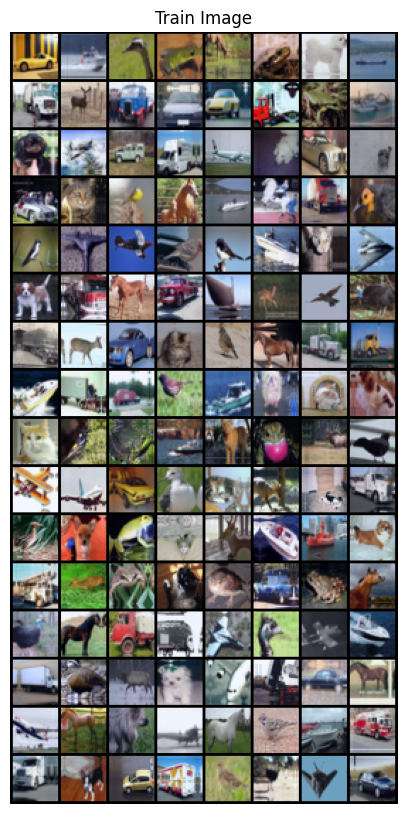

In [6]:
#CIFAR 10에는 다음과 같은 그림이 들어있습니다.
#총 10개의 class
train_iter = iter(train_loader)
images, labels = next(train_iter)

imshow(images, "Train Image")


In [7]:
images.shape # 각 image의 size는 32*32이며, batch size = 128, channel = 3(color)입니다.

torch.Size([128, 3, 32, 32])

In [8]:
import torch
import torch.nn as nn


class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_1x1, reduce_3x3, out_3x3, reduce_5x5, out_5x5, out_1x1_pool):
        super(InceptionModule, self).__init__()

        # 1x1 conv branch
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, out_1x1, kernel_size=1),
            nn.BatchNorm2d(out_1x1),
            nn.ReLU(inplace=True)
        )

        # 3x3 conv branch
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, reduce_3x3, kernel_size=1),
            nn.BatchNorm2d(reduce_3x3),
            nn.ReLU(inplace=True),
            nn.Conv2d(reduce_3x3, out_3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_3x3),
            nn.ReLU(inplace=True)
        )

        # 5x5 conv branch
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, reduce_5x5, kernel_size=1),
            nn.BatchNorm2d(reduce_5x5),
            nn.ReLU(inplace=True),
            nn.Conv2d(reduce_5x5, out_5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(out_5x5),
            nn.ReLU(inplace=True)
        )

        # max pooling branch
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_1x1_pool, kernel_size=1),
            nn.BatchNorm2d(out_1x1_pool),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        output = torch.cat([branch1, branch2, branch3, branch4], dim=1)

        return output


## 이번에는 직접 모델을 만들어 보도록 하겠습니다.

MNIST 실습파일과는 다르게 정답이 정해지지 않았으며, 오류가 나지 않도록 원하시는 대로 숫자를 넣어 코드를 돌리고 제출해주세요!

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class GoogLeNet(nn.Module):

    def __init__(self):
        super(GoogLeNet, self).__init__()
        
        # First convolutional layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.norm1 = nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75)
        
        # Second convolutional layer
        self.conv2_reduce = nn.Conv2d(64, 64, kernel_size=1)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
        self.norm2 = nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Inception modules
        self.inception3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.inception4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionModule(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionModule(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionModule(528, 256, 160, 320, 32, 128, 128)
        self.pool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.inception5a = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionModule(832, 384, 192, 384, 48, 128, 128)
        
        # Classification layer
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=0.4)
        self.fc = nn.Linear(1024, 10)

    def forward(self, x):
    # First convolutional layer
      x = self.conv1(x)
      x = F.relu(x)
      x = self.pool1(x)
      x = self.norm1(x)

      # Second convolutional layer
      x = self.conv2_reduce(x)
      x = F.relu(x)
      x = self.conv2(x)
      x = F.relu(x)
      x = self.norm2(x)
      x = self.pool2(x)

      # Inception modules
      x = self.inception3a(x)
      x = self.inception3b(x)
      x = self.pool3(x)
      x = self.inception4a(x)
      x = self.inception4b(x)
      x = self.inception4c(x)
      x = self.inception4d(x)
      x = self.inception4e(x)
      x = self.pool4(x)
      x = self.inception5a(x)
      x = self.inception5b(x)

      # Classification layer
      x = self.avg_pool(x)
      x = self.dropout(x)
      x = x.view(x.size(0), -1)
      x = self.fc(x)

      return x

    
model = GoogLeNet().cuda()

In [20]:
# Define your model architecture and loss function
loss_fn = nn.CrossEntropyLoss()

# Define your optimizer with weight decay (AdamW)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)


## 14.3 Train Model

In [25]:
# parameter setting
num_epochs = 60


In [27]:
# Move the model to the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Train the model for the specified number of epochs
for epoch in range(num_epochs):
    # Train the model
    train_loss = 0.0
    model.train()
    for batch_images, batch_labels in train_loader:
        # Move the data to the GPU
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)

        # Forward pass
        outputs = model(batch_images)
        loss = loss_fn(outputs, batch_labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the training loss
        train_loss += loss.item() * batch_images.size(0)
    

    # Calculate the average training loss for the epoch
    avg_train_loss = train_loss / len(train_data)
    # Evaluate the model on the validation set
    valid_loss = 0.0
    model.eval()
    with torch.no_grad():
        for batch_images, batch_labels in val_loader:
            # Move the data to the GPU
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)

            # Forward pass
            outputs = model(batch_images)
            loss = loss_fn(outputs, batch_labels)

            # Update the validation loss
            valid_loss += loss.item() * batch_images.size(0)

    # Calculate the average validation loss for the epoch
    avg_valid_loss = valid_loss / len(val_data)

    # Print the training and validation losses for the epoch
    print('Epoch [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
          .format(epoch+1, num_epochs, avg_train_loss, avg_valid_loss))


Epoch [1/60], Train Loss: 0.8051
Epoch [1/60], Train Loss: 0.8051, Valid Loss: 0.9597
Epoch [2/60], Train Loss: 0.7410
Epoch [2/60], Train Loss: 0.7410, Valid Loss: 0.9759
Epoch [3/60], Train Loss: 0.6976
Epoch [3/60], Train Loss: 0.6976, Valid Loss: 0.8136
Epoch [4/60], Train Loss: 0.6933
Epoch [4/60], Train Loss: 0.6933, Valid Loss: 0.8532
Epoch [5/60], Train Loss: 0.6548
Epoch [5/60], Train Loss: 0.6548, Valid Loss: 0.7484
Epoch [6/60], Train Loss: 0.6216
Epoch [6/60], Train Loss: 0.6216, Valid Loss: 0.7315
Epoch [7/60], Train Loss: 0.5945
Epoch [7/60], Train Loss: 0.5945, Valid Loss: 0.7188
Epoch [8/60], Train Loss: 0.5765
Epoch [8/60], Train Loss: 0.5765, Valid Loss: 0.7089
Epoch [9/60], Train Loss: 0.5770
Epoch [9/60], Train Loss: 0.5770, Valid Loss: 0.6914
Epoch [10/60], Train Loss: 0.5424
Epoch [10/60], Train Loss: 0.5424, Valid Loss: 0.6538
Epoch [11/60], Train Loss: 0.5220
Epoch [11/60], Train Loss: 0.5220, Valid Loss: 0.7495
Epoch [12/60], Train Loss: 0.5058
Epoch [12/60], T

## 14.4 Test Model

In [28]:
correct = 0
total = 0

# Set the model to evaluation mode
model.eval()

with torch.no_grad():
    for images, labels in test_loader:

        images = images.cuda()
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum()

print('Accuracy of test images: %f %%' % (100 * float(correct) / total))


Accuracy of test images: 83.250000 %


Predicted:    cat  ship  ship plane  frog


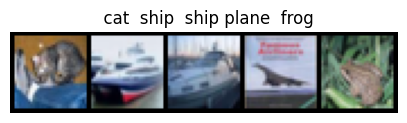

In [29]:
data_iter = iter(test_loader)
images, labels = next(data_iter)

# rest of your code for prediction and displaying the images

outputs = model(images.cuda())

_, predicted = torch.max(outputs.data, 1)
    
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(5)))

title = (' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(images, title)